<a href="https://colab.research.google.com/github/Apoorva-Bedekar/Twitter-Sentiment-Classification-using-Deep-Learning/blob/main/DL_Project_21201694.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP47650 - Deep Learning Project 

## Twitter Sentiment Analysis 

### Submitted by - Apoorva Bedekar (21201694)

> In this project I will be using B.2 (Text) Classification dataset. It is a Twitter sentiment analysis for multi-class clasiification for analysing polarity of the sentiment. The following are my target classes :
 1. extremely negative
 2. negative
 3. neutral 
 4. positive 
 5. extremely positive

The main challenge in this dataset was sequential and require a robust model. 
I will be doing an exploratory analysis of the data, clean it, and then used ngrams for preprocessing.

*   Cross Entropy loss for criterion 
*   Stochastic Gradient Classification for optimizer 
*   LR Scheduler Step LR for scheduler. 




 

#### Importing required libraries

In [2]:
import pandas as pd
import nltk
from collections import Counter
from matplotlib.pyplot import plot, hist, xlabel, legend
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import io
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import logging
import warnings
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)
warnings.filterwarnings("ignore")
from google.colab import files

#### Loading Data 

In [3]:
train = files.upload()
test = files.upload()

Saving Corona_NLP_train.csv to Corona_NLP_train.csv


Saving Corona_NLP_test.csv to Corona_NLP_test.csv


In [4]:
train= pd.read_csv(io.BytesIO(train['Corona_NLP_train.csv']), encoding='latin-1')
test = pd.read_csv(io.BytesIO(test['Corona_NLP_test.csv']),encoding='latin-1')

#### Initital analysis of the data

1.   Training and testing shape 
2.   Memory usage
3.   Null Values



In [5]:
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Training Set Shape = (41157, 6)
Training Set Memory Usage = 1.88 MB
Test Set Shape = (3798, 6)
Test Set Memory Usage = 0.17 MB


In [6]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
print('Data available for each target class: \n')
print(train.groupby('Sentiment').size())

Data available for each target class: 

Sentiment
Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7713
Positive              11422
dtype: int64


### Preprocessing the Text Data


#### Getting Target Classes 
Here we convert our 5 sentiment polarities into 5 numerical classes. 

*   Extremely Negative - 0
*   Negative - 1
*   Neutral - 2 
*   Positive - 3
*   Extremely Positive - 4

In [8]:
def get_target_class(df) :
    df['Target_class'] = df['Sentiment'].replace('Extremely Negative', 0).replace('Negative',1).replace('Neutral',2).replace('Positive',3).replace('Extremely Positive',4)
    return df

In [9]:
train_data = get_target_class(train)
test_data = get_target_class(test)

#### Dropping column irrelevant to the analysis

In [11]:
train_data = train_data.drop(['UserName','ScreenName','Location','TweetAt','Sentiment'], axis = 1)
test_data = test_data.drop(['UserName','ScreenName','Location','TweetAt','Sentiment'], axis = 1)

####  Preprocessing 
We perform basic text preprocessing since this data does not have much noise. 
*   Converting all tweet text to lower case for uniformity
*   Removing Stopwords
*   Count unique words to get vocabulary. 

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [14]:
train_data['raw_text']=  train_data.OriginalTweet.map(remove_stopwords)
test_data['raw_text']= test_data.OriginalTweet.map(remove_stopwords) 

In [15]:
train_data.head()

,OriginalTweet,Target_class,raw_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,@menyrbie @phil_gahan @chrisitv https://t.co/i...
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia: woolworths give elderly...
3,My food stock is not the only one which is emp...,3,"food stock one empty... please, panic, enough ..."
4,"Me, ready to go at supermarket during the #COV...",0,"me, ready go supermarket #covid19 outbreak. i'..."


#### Getting Vocabulary

In [16]:
train_counter = counter_word(train_data.raw_text)
test_counter = counter_word(test_data.raw_text)

In [18]:
train_vocab = len(train_counter)
test_vocab = len(test_counter)

print('Training Vocabulary %s'% len(train_counter))
print('Test Vocabulary %s'% len(test_counter))


Training Vocabulary 120642
Test Vocabulary 20457


#### Tokenizing, embedding and padding the text data



In [19]:
train_data['train_sentences'] = train_data.raw_text.to_numpy()
test_data['test_sentences'] = test_data.raw_text.to_numpy()

In [20]:
train_data['train_sentences'].shape, test_data['test_sentences'].shape

((41157,), (3798,))

In [21]:
train_data.head()

,OriginalTweet,Target_class,raw_text,train_sentences
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,@menyrbie @phil_gahan @chrisitv https://t.co/i...,@menyrbie @phil_gahan @chrisitv https://t.co/i...
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia: woolworths give elderly...,coronavirus australia: woolworths give elderly...
3,My food stock is not the only one which is emp...,3,"food stock one empty... please, panic, enough ...","food stock one empty... please, panic, enough ..."
4,"Me, ready to go at supermarket during the #COV...",0,"me, ready go supermarket #covid19 outbreak. i'...","me, ready go supermarket #covid19 outbreak. i'..."


Removing special symbols 

In [22]:
tokenizer = Tokenizer(num_words=120000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [23]:
tokenizer.fit_on_texts(train_data['train_sentences'])
tokenizer.fit_on_texts(test_data['test_sentences'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 87224 unique tokens.


Creating Sequences

In [25]:
train_data['train_sequences'] = tokenizer.texts_to_sequences(train_data['train_sentences'])
test_data['test_sequences'] = tokenizer.texts_to_sequences(test_data['test_sentences'])

In [26]:
train_data.head()

,OriginalTweet,Target_class,raw_text,train_sentences,train_sequences
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,@menyrbie @phil_gahan @chrisitv https://t.co/i...,@menyrbie @phil_gahan @chrisitv https://t.co/i...,"[25342, 7577, 25343, 14091, 3, 2, 1, 25344, 3,..."
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...,advice talk neighbours family exchange phone n...,"[429, 831, 2384, 183, 2661, 794, 1252, 1072, 3..."
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia: woolworths give elderly...,coronavirus australia: woolworths give elderly...,"[4, 795, 1607, 242, 216, 1328, 1906, 16, 181, ..."
3,My food stock is not the only one which is emp...,3,"food stock one empty... please, panic, enough ...","food stock one empty... please, panic, enough ...","[7, 22, 34, 123, 37, 20, 166, 7, 67, 65, 21, 4..."
4,"Me, ready to go at supermarket during the #COV...",0,"me, ready go supermarket #covid19 outbreak. i'...","me, ready go supermarket #covid19 outbreak. i'...","[307, 664, 28, 10, 14, 73, 137, 4057, 7, 22, 2..."


Defining embedding dimension, trucating type, and padding type and maximum number of characters in a sentence. 
> Truncate and pad the input sequences so that they are all in the same length for modeling.
> Vectorize Tweet text, by turning each text into either a sequence of integers or into a vector.

In [28]:
embedding_dim = 100
trunc_type='post'
padding_type='post'
# Max number of characters in a Tweet is 140 
max_length = 140

In [31]:
train_padded = pad_sequences(train_data['train_sequences'], maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_data['test_sequences'], maxlen=max_length, padding=padding_type, truncating=padding_type)

print('Shape of training data tensor:', train_padded.shape)
print('Shape of testing data tensor:', test_padded.shape)

Shape of training data tensor: (41157, 140)
Shape of testing data tensor: (3798, 140)


In [32]:
train_padded

array([[25342,  7577, 25343, ...,     0,     0,     0],
       [  429,   831,  2384, ...,     0,     0,     0],
       [    4,   795,  1607, ...,     0,     0,     0],
       ...,
       [   62,   116,   147, ...,     0,     0,     0],
       [  655,  4428,    32, ...,     0,     0,     0],
       [82623,   118,    43, ...,     0,     0,     0]], dtype=int32)

In [33]:
train_target_class = train_data['Target_class'].to_numpy()
test_target_class = train_data['Target_class'].to_numpy()

print('Shape of label tensor:', train_target_class.shape)
print('Shape of label tensor:', test_target_class.shape)


Shape of label tensor: (41157,)
Shape of label tensor: (41157,)


In [34]:
train_target_class

array([2, 3, 3, ..., 3, 2, 1])

#### Split Training data into Training and Validation Dataset

In [35]:
x_train,x_val,y_train,y_val = train_test_split(train_padded,train_target_class, test_size=0.33)

#### Function to plot graphs for loss and accuracy 

In [36]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

### Training different Models 

*  LSTM 
*  CONV1D + GlobalMaxPooling1D
*  GRU 
*  LSTM + GRU
*  SpatialDropout1D + LSTM

#### RNN Bidirectional LSTM

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(120000, embedding_dim, input_length = max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,kernel_regularizer=tf.keras.regularizers.L2(0.001)))) 
#L2 Regularizers for avoiding overfitting 
model.add(tf.keras.layers.Dropout(0.5)) #To avoid overfitting 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5, activation="softmax")) 
model.summary()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)
num_epochs = 10

history = model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 100)          12000000  
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 5)                 1005      
                                                                 
Total params: 12,161,805
Trainable params: 12,161,805
Non-trainable params: 0
____________________________________________

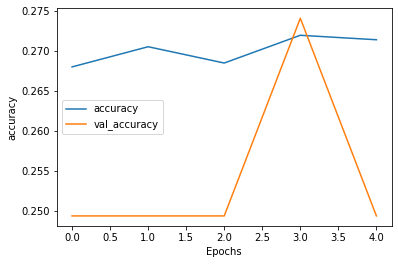

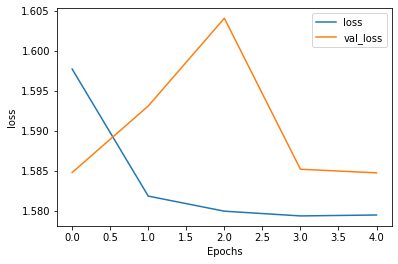

In [44]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

#### CONV 1D + GlobalMaxPooling1D

In [34]:
modell = tf.keras.Sequential([
    tf.keras.layers.Embedding(120000, embedding_dim,input_length = max_length),
    tf.keras.layers.Conv1D(128, 5),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(5, activation='softmax')
])

modell.summary()

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

modell.compile(loss=loss, optimizer=optim, metrics=metrics)

num_epochs = 10


history1 = modell.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 140, 100)          12000000  
                                                                 
 conv1d_2 (Conv1D)           (None, 136, 128)          64128     
                                                                 
 dropout_6 (Dropout)         (None, 136, 128)          0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                     

KeyboardInterrupt: ignored

In [ ]:
plot_graphs(history1, 'accuracy')
plot_graphs(history1, 'loss')

#### GRU

In [27]:
model3 =  tf.keras.Sequential()
model3.add( tf.keras.layers.Embedding(120000, embedding_dim,input_length = max_length))
model3.add( tf.keras.layers.GRU(150, recurrent_dropout=0.5))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add( tf.keras.layers.Dense(5, activation='softmax'))
model3.summary()

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model3.compile(loss=loss, optimizer=optim, metrics=metrics)

num_epochs = 10


history3 = model3.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs,batch_size =batch_size , verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 140, 100)          12000000  
                                                                 
 gru_3 (GRU)                 (None, 150)               113400    
                                                                 
 dense_5 (Dense)             (None, 5)                 755       
                                                                 
Total params: 12,114,155
Trainable params: 12,114,155
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
644/644 [==============================] - 504s 776ms/step - loss: 1.5770 - accuracy: 0.2728 - val_loss: 1.5930 - val_accuracy: 0.2493
Epoch 2/50
644/644 [==============================] - 464s 721ms/step - loss: 1.5764 - accuracy: 0.2771 - val_loss: 1.5839 - val_accuracy: 0.2493
Epoch 3/50
202

KeyboardInterrupt: ignored

In [ ]:
plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')

#### LSTM + GRU

In [ ]:
model4 =  tf.keras.Sequential()
model4.add( tf.keras.layers.Embedding(120000, embedding_dim,input_length = max_length))
model4.add(tf.keras.layers.LSTM(100))
model4.add(tf.keras.layers.Dropout(0.5))
model4.add( tf.keras.layers.GRU(150, recurrent_dropout=0.5))
model4.add(tf.keras.layers.Dropout(0.5))
model4.add( tf.keras.layers.Dense(5, activation='softmax'))
model4.summary()


loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model4.compile(loss=loss, optimizer=optim, metrics=metrics)

num_epochs = 10
batch_size = 64


history4 = model4.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs,batch_size =batch_size , verbose=1)

In [ ]:
plot_graphs(history4, 'accuracy')
plot_graphs(history4, 'loss')

#### SpatialDropout1D + LSTM

In [41]:
model5 =  tf.keras.Sequential()
model5.add( tf.keras.layers.Embedding(120000, embedding_dim, input_length = max_length))
model5.add( tf.keras.layers.SpatialDropout1D(0.5))
model5.add(tf.keras.layers.Dropout(0.5))
model5.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)))
model5.add(tf.keras.layers.Dropout(0.5))
model5.add(tf.keras.layers.Dense(5, activation='softmax'))

model5.summary()


loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model5.compile(loss=loss, optimizer=optim, metrics=metrics)

num_epochs = 10

history5 = model5.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs , verbose=1)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 100)         12000000  
                                                                 
 spatial_dropout1d_3 (Spatia  (None, None, 100)        0         
 lDropout1D)                                                     
                                                                 
 dropout_13 (Dropout)        (None, None, 100)         0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 200)               0         
                                                                 
 dense_16 (Dense)            (None, 5)               

KeyboardInterrupt: ignored

In [ ]:
plot_graphs(history5, 'accuracy')
plot_graphs(history5, 'loss')

## Evaluation - Best model 


In [ ]:
plot_graphs(accuracy, 'accuracy')
plot_graphs(accuracy, 'loss')